<a href="https://colab.research.google.com/github/elonezra/deeplearningproject/blob/main/final_project_deep_learning_course.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authors: Avi and Elon 🤗

## Pre-Processing the data

In [122]:
# Importng necassary libraries
import pandas as pd
import numpy as np
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.dummy import DummyRegressor

In [123]:
df = pd.read_csv('BTC-USD.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [124]:
# We don't need the "Adj Close" column because this column is the same as the "Close" column,
# we are going to check it before earasing to make sure our assumption is true.
print(df['Adj Close'].count(), df['Close'].count()) # In this line we can see that the number of lines in both of the columns is equal
print(len(df["Close"] == df["Adj Close"])) # and in this line we compared between those columns and get as result that all lines are equal
# thus, we can remove "Asj Close" column
df = df.drop(['Adj Close'], axis = 1)
df.head()

2713 2713
2713


,Date,Open,High,Low,Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


In [125]:
# now we want to change the 'Close' column to be 'Open_Close_Gap' column because,
# it's more common to predict the mean between the Open price and the Close price
df['Close'].rename('Open_Close_Gap')
df['Open_Close_Gap'] = (df['Open'] - df['Close'])
df = df.drop(['Close'], axis=1)

In [126]:
# In the code below we will see that our dataframe uses an object column which is not good
# because we need a numeric dataframe so, we convert this column to int64 type
# by removing the '-' char
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2713 entries, 0 to 2712
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            2713 non-null   object 
 1   Open            2713 non-null   float64
 2   High            2713 non-null   float64
 3   Low             2713 non-null   float64
 4   Volume          2713 non-null   int64  
 5   Open_Close_Gap  2713 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 127.3+ KB


In [127]:
int(df.iloc[1][0].replace('-', ''))

C:\Users\elone\AppData\Local\Temp\ipykernel_8524\84532947.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  int(df.iloc[1][0].replace('-', ''))


20140918

In [128]:
df["Date"] = df["Date"].apply(lambda x: x.replace('-','')).apply(pd.to_numeric)

In [129]:
# Now, after we convert the "Date" column to numeric type, we can see the new data as request
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2713 entries, 0 to 2712
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            2713 non-null   int64  
 1   Open            2713 non-null   float64
 2   High            2713 non-null   float64
 3   Low             2713 non-null   float64
 4   Volume          2713 non-null   int64  
 5   Open_Close_Gap  2713 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 127.3 KB


,Date,Open,High,Low,Volume,Open_Close_Gap
0,20140917,465.864014,468.174011,452.421997,21056800,8.529999
1,20140918,456.859985,456.859985,413.104004,34483200,32.419983
2,20140919,424.102997,427.834991,384.532013,37919700,29.307007
3,20140920,394.673004,423.295990,389.882996,36863600,-14.230988
4,20140921,408.084991,412.425995,393.181000,26580100,9.263977


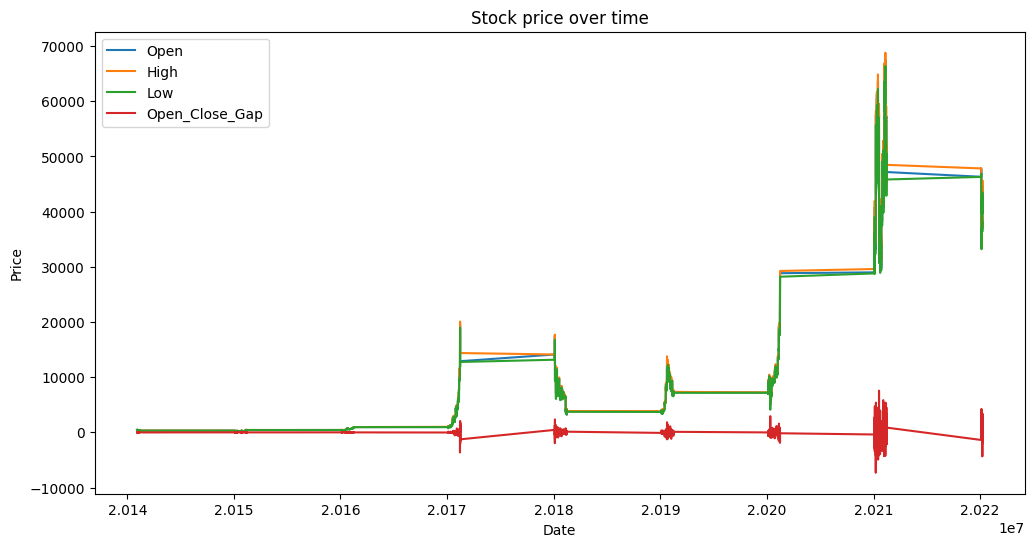

In [130]:
# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Plot the data
df[['Open', 'High', 'Low', 'Open_Close_Gap']].plot(kind='line', figsize=(12,6))
plt.title('Stock price over time')
plt.ylabel('Price')
plt.show()




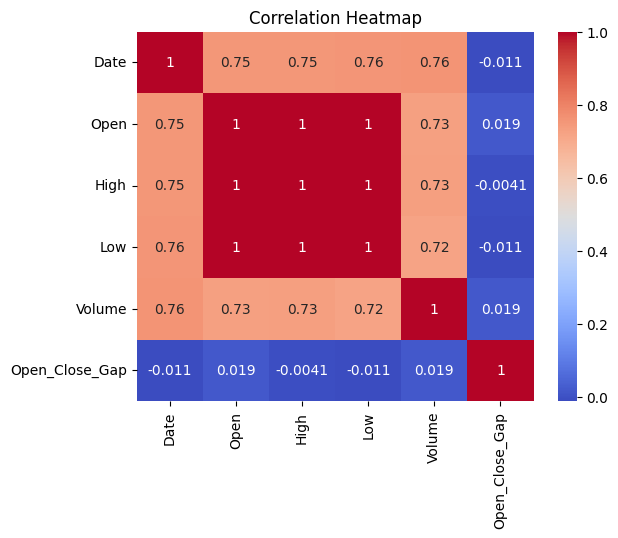

In [131]:
# Calculate the correlation matrix
df = df.reset_index()
corr = df[['Date', 'Open', 'High', 'Low', 'Volume', 'Open_Close_Gap']].corr()

# Plot the heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


High correlation coefficients (close to +1 or -1) between two or more variables indicate high multicollinearity which means that our data has high multicollinearity which is not good because it means that two or more explanatory variables in a multiple regression model are highly linearly related.

We check the multicollinearity with another technique called Variance Inflation Factor (VIF) which is indicate how much the variance is inflated due to multicollinearity.

In [132]:
X = df.drop(['Open_Close_Gap'], axis=1)

# Assuming X is your feature matrix
vif = pd.DataFrame()
vif["features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


  features          VIF
0     Date     1.626099
1     Open  1271.779503
2     High  1302.971806
3      Low   690.369679
4   Volume     3.795683


open: The VIF of 1899.216794 suggests a high degree of multicollinearity with the other variables.
high: Similarly, a VIF of 1933.193722 also indicates high multicollinearity.
low: A VIF of 1017.898356 is also high, suggesting this variable is highly correlated with others.
volume: A VIF of 3.492894 is relatively low compared to the others, suggesting less multicollinearity.

Generally, a VIF above 5 or 10 indicates high multicollinearity that might be problematic for our model. With this case, the “open”, “high”, and “low” features have high VIF values, suggesting they are highly correlated with each other.

We should use techinques to handle the high multicollinearity, one way we learned in the class is the "Regularization" technique, we will use it to make our data less multicollinearity.

# Regularization

$\sigma = \sqrt(\mu_2) = \sqrt(1/n \sum(x_i - x')^2)$

$𝜇^{𝑙,𝑗}= \frac{1}{m} ∑_{𝑖=0}^{𝑚}{𝑧_𝑖^{𝑙,𝑗}}$ 

$𝜎^{𝑙,𝑗}=\sqrt{∑_{𝑖=0}^𝑚(𝑧_𝑖^{𝑙,𝑗}−𝜇^(𝑙,𝑗) )^2 }$

$\overline{𝑧_𝑖^{𝑙,𝑗}} ̂= \frac{𝑧_𝑖^{𝑙,𝑗}−𝜇^{𝑙,𝑗}}{𝜎^{𝑙,𝑗}+𝜖} $


In [133]:
X = df.drop(['Open_Close_Gap'], axis=1)
y = df['Open_Close_Gap']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))


Training set size: 2170
Testing set size: 543


# Normalization

In [134]:
def normalize_data(X_train, y_train, X_test, y_test):
    """
    This function normalizes the training and test data using the mean and variance of the training data.
    
    Parameters:
    X_train (DataFrame): The training data
    y_train (Series): The target values for the training data
    X_test (DataFrame): The test data
    y_test (Series): The target values for the test data
    
    Returns:
    DataFrame, Series, DataFrame, Series: The normalized training data, training target values, test data, and test target values
    """
    # Convert the dataframes to numpy arrays
    train_np = X_train.values
    test_np = X_test.values

    # Convert the series to numpy arrays
    y_train_np = y_train.values.reshape(-1, 1)
    y_test_np = y_test.values.reshape(-1, 1)

    # Create TensorFlow placeholders
    train_placeholder = tf.placeholder(tf.float32, shape=train_np.shape)
    test_placeholder = tf.placeholder(tf.float32, shape=test_np.shape)
    y_train_placeholder = tf.placeholder(tf.float32, shape=y_train_np.shape)
    y_test_placeholder = tf.placeholder(tf.float32, shape=y_test_np.shape)

    # Define the normalization function
    def normalize(x, mean, variance):
        return (x - mean) / tf.sqrt(variance)

    # Normalize the data
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        # Compute mean and variance from training data
        train_mean, train_variance = sess.run(tf.nn.moments(train_placeholder, axes=[0]), feed_dict={train_placeholder: train_np})
        
        # Normalize training data
        train_normalized = sess.run(normalize(train_placeholder, train_mean, train_variance), feed_dict={train_placeholder: train_np})
        
        # Normalize test data using mean and variance from training data
        test_normalized = sess.run(normalize(test_placeholder, train_mean, train_variance), feed_dict={test_placeholder: test_np})
        
        # Normalize y_train and y_test similarly
        y_train_mean, y_train_variance = sess.run(tf.nn.moments(y_train_placeholder, axes=[0]), feed_dict={y_train_placeholder: y_train_np})
        y_train_normalized = sess.run(normalize(y_train_placeholder, y_train_mean, y_train_variance), feed_dict={y_train_placeholder: y_train_np})
        y_test_normalized = sess.run(normalize(y_test_placeholder, y_train_mean, y_train_variance), feed_dict={y_test_placeholder: y_test_np})

    # Convert the normalized numpy arrays back to pandas dataframes
    X_train_normalized = pd.DataFrame(train_normalized, columns=X_train.columns)
    X_test_normalized = pd.DataFrame(test_normalized, columns=X_test.columns)

    # Convert the normalized numpy arrays back to pandas series
    y_train_normalized = pd.Series(y_train_normalized.flatten(), index=y_train.index)
    y_test_normalized = pd.Series(y_test_normalized.flatten(), index=y_test.index)

    return X_train_normalized, y_train_normalized, X_test_normalized, y_test_normalized


In [135]:
X_train_normalized, y_train_normalized, X_test_normalized, y_test_normalized = normalize_data(X_train, y_train, X_test, y_test)
print("Training set size:", len(X_train_normalized))
print("Testing set size:", len(X_test_normalized))


Training set size: 2170
Testing set size: 543


# Model training
Models that represented in the code: Linear regression, ANN - neural network model, dummy regressor model - to compare our model to that dummy model

In [136]:
def train_linear_regression(X_train, y_train, learning_rate=0.001, threshold=0.0001):
    """
    This function trains a linear regression model using TensorFlow.
    
    Parameters:
    X_train (DataFrame): The training data
    y_train (Series): The target values for the training data
    learning_rate (float): The learning rate for the optimizer
    threshold (float): The threshold for the change in loss
    
    Returns:
    sess (tf.Session): The TensorFlow session
    pred (Tensor): The prediction tensor
    x (tf.placeholder): The placeholder for the input data
    """
    features = X_train.shape[1]
    x = tf.placeholder(tf.float32, [None, features])
    y = tf.placeholder(tf.float32, [None, 1])
    W = tf.Variable(tf.zeros([features, 1]))
    b = tf.Variable(tf.zeros([1]))
    prev_loss = None
    pred = tf.matmul(x, W) + b
    loss = tf.reduce_mean(tf.square(pred - y))
    update = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    data_x = X_train.values
    data_y = y_train.values.reshape(-1, 1)
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    i = 0
    while True:
        i += 1
        _, val_loss = sess.run([update, loss], feed_dict={x: data_x, y: data_y})
        if prev_loss is not None and abs(prev_loss - val_loss) < threshold:
            print(f"Early stopping at epoch {i}")
            break
        prev_loss = val_loss
        if i % 10000 == 0:
            print('\nIteration:', i, '\n W:', sess.run(W), ' b:', sess.run(b), ' loss:', loss.eval(session=sess, feed_dict={x: data_x, y: data_y}))
    return sess, pred, x

In [137]:
def train_neural_network(X_train, y_train, learning_rate=0.00001, epochs=100000):
    """
    This function trains a neural network with one hidden layer using TensorFlow.
    
    Parameters:
    X_train (DataFrame): The training data
    y_train (Series): The target values for the training data
    learning_rate (float): The learning rate for the optimizer
    epochs (int): The number of epochs to train the model
    
    Returns:
    sess (tf.Session): The TensorFlow session
    pred (Tensor): The prediction tensor
    x (tf.placeholder): The placeholder for the input data
    """
    features = X_train.shape[1]
    x = tf.placeholder(tf.float32, [None, features])
    y = tf.placeholder(tf.float32, [None, 1])
    W1 = tf.Variable(tf.random_normal([features, 10]))
    b1 = tf.Variable(tf.zeros([10]))
    W2 = tf.Variable(tf.random_normal([10, 1]))
    b2 = tf.Variable(tf.zeros([1]))
    hidden_layer = tf.nn.relu(tf.matmul(x, W1) + b1)
    pred = tf.matmul(hidden_layer, W2) + b2
    loss = tf.reduce_mean(tf.square(pred - y))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    data_x = X_train.values
    data_y = y_train.values.reshape(-1, 1)
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    for epoch in range(0, epochs):
        _, c = sess.run([optimizer, loss], feed_dict={x: data_x, y: data_y})
        if epoch % 1000 == 0:
            print("Epoch:", '%04d' % (epoch), "cost=", "{:.9f}".format(c))
    return sess, pred, x

# Replace the Built-in dummy model with our dummy model, predicting 0 for the Open_Close_Gap

#### Create dummy model

In [138]:
def dummy_regressor(y_train):
    """
    This function creates a dummy regressor that predicts the mean value of the target variable.
    
    Parameters:
    X_train (DataFrame): The training data
    y_train (Series): The target values for the training data
    
    Returns:
    y_pred (ndarray): The predicted values
    """
    y_pred = [(np.random.uniform(-1,1)) for i in range(len(y_train))]
    return y_pred

In [139]:
dummy_pred = dummy_regressor(y_test_normalized)
print("y_dummy_pred:", dummy_pred)

y_dummy_pred: [-0.4162755620672802, -0.7674424951223426, 0.8754467361262122, -0.5665727541342389, 0.016913507704575004, -0.2821814473801829, -0.22387923930423947, 0.6480741355999158, 0.39192212379793934, 0.8841295224214867, 0.899806134195186, 0.7896240541132589, -0.4070928615891203, -0.5892599785398345, 0.03561795447034233, -0.13004399148244095, 0.842498401265668, 0.3495355309536139, 0.9516546680378888, 0.11487647978904936, 0.5355567712943154, -0.43646662839965833, 0.9129482635348887, 0.3759494201120206, -0.24400262163957653, -0.3594137862182296, 0.1343408424285466, -0.8217465697157216, -0.7016319199661312, -0.5323677009963963, -0.9417267552520683, 0.738082549830742, 0.6144863882641032, -0.8424709782577651, 0.2485217606468264, -0.3523879674834425, -0.7612074078818767, 0.27671509852548737, -0.0017312094686194879, 0.3135461177691947, 0.921794171026801, -0.7911001539133291, -0.41037780927158907, -0.762040965856988, -0.050276892372471016, 0.7415919840845226, -0.4302575264891446, -0.7861166

In [143]:
# Train the models
print("Training Linear Regression model...")
sess_linear, pred_linear, x_linear = train_linear_regression(X_train_normalized, y_train_normalized, learning_rate=0.01, threshold=0.0000000000001)
print("Training Neural Network model...")
sess_nn, pred_nn, x_nn = train_neural_network(X_train_normalized, y_train_normalized, learning_rate=0.00001, epochs=10000) 

# Make predictions
y_pred_linear = sess_linear.run(pred_linear, feed_dict={x_linear: X_test_normalized.values})
y_pred_nn = sess_nn.run(pred_nn, feed_dict={x_nn: X_test_normalized.values})

# Calculate R-Squared score
r2_linear = r2_score(y_test_normalized, y_pred_linear)
r2_nn = r2_score(y_test_normalized, y_pred_nn)
r2_dummy = r2_score(y_test_normalized, dummy_pred)

mse_linear = mean_squared_error(y_test_normalized, y_pred_linear)
mse_nn = mean_squared_error(y_test_normalized, y_pred_nn)
mse_dummy = mean_squared_error(y_test_normalized, dummy_pred)

print(f"Linear Regression R-Squared score is: {r2_linear} and MSE on the test set is: {mse_linear}")
print(f"Neural Network R-Squared score is: {r2_nn} and MSE on the test set is: {mse_nn}")
print(f"Dummy Model R-Squared score is: {r2_dummy} and MSE on the test set is: {mse_dummy}")

Training Linear Regression model...

Iteration: 10000 
 W: [[-0.04676987]
 [ 3.4416952 ]
 [-1.056574  ]
 [-2.3524497 ]
 [ 0.03947638]]  b: [6.837758e-05]  loss: 0.8108598

Iteration: 20000 
 W: [[-2.1004800e-02]
 [ 6.4455943e+00]
 [-2.1231716e+00]
 [-4.2780738e+00]
 [-2.2372708e-03]]  b: [3.1800595e-05]  loss: 0.6718761

Iteration: 30000 
 W: [[-1.3473415e-03]
 [ 9.0789042e+00]
 [-3.1753907e+00]
 [-5.8504267e+00]
 [-3.3865441e-02]]  b: [3.8715384e-06]  loss: 0.5665248

Iteration: 40000 
 W: [[ 0.01339069]
 [11.393152  ]
 [-4.201478  ]
 [-7.1322    ]
 [-0.05739504]]  b: [-1.7083687e-05]  loss: 0.48585612

Iteration: 50000 
 W: [[ 0.02419347]
 [13.432026  ]
 [-5.1928873 ]
 [-8.175158  ]
 [-0.07443843]]  b: [-3.2459902e-05]  loss: 0.4234723

Iteration: 60000 
 W: [[ 0.03183892]
 [15.232176  ]
 [-6.143442  ]
 [-9.021725  ]
 [-0.08632819]]  b: [-4.3350814e-05]  loss: 0.3747793

Iteration: 70000 
 W: [[ 0.03699317]
 [16.82554   ]
 [-7.049427  ]
 [-9.707239  ]
 [-0.09412494]]  b: [-5.072836e-

# Comparison between models

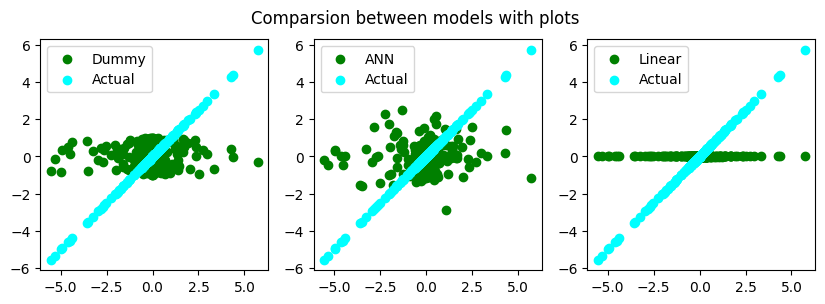

In [141]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))
fig.suptitle('Comparsion between models with plots')

ax1.scatter(y_test_normalized, dummy_pred, color='green', label='Dummy')
ax1.scatter(y_test_normalized, y_test_normalized, color='cyan', label='Actual')
ax1.legend()

ax2.scatter(y_test_normalized, y_pred_nn, color='green', label='ANN')
ax2.scatter(y_test_normalized, y_test_normalized, color='cyan', label='Actual')
ax2.legend()

ax3.scatter(y_test_normalized, y_pred_linear, color='green', label='Linear')
ax3.scatter(y_test_normalized, y_test_normalized, color='cyan', label='Actual')
ax3.legend()
